In [1]:
import os
import io
import json
import numpy as np
from glob import glob
import pandas as pd
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
def load_csv(file):
    data = pd.read_csv(file)
    return data

def load_json(file):
    with open(file, 'r') as f:
        data = json.load(f)
    return data

def save_df(df, save_file_to=None):
    assert save_file_to is not None, 'save_file_to is None'
    df.to_csv(save_file_to, index=False)


In [3]:

class ProcessLogs:
    def __init__(self, pattern='./logs/*/*/*/rank_0/'):
        self.args_files = glob(pattern+'args.json')
        self.is_valid = len(self.args_files) > 0
        assert self.is_valid, f'''Invalid pattern: {pattern}, {len(self.args_files)} args json files found'''
        self.init()

    def init(self):
        self.results = {}
        self.invalid_exps = []
        num = len(self.args_files)
        for i in range(num):
            args = load_json(self.args_files[i])
            key, keys2values = self.args2key(args)
            
            csv_file = glob(self.args_files[i].replace('args.json', 'stat_log.csv'))
            if len(csv_file) == 0:
                # print(self.args_files[i])
                self.invalid_exps.append(self.args_files[i])
                # print(self.args_files[i].replace('rank_0/args.json', ''))
                ThroughPut = 0
                GPU_Peak_Memory = 0
                GPU_Peak_Memory_std = 0
                CPU_Peak_Memory = 0
                CPU_Peak_Memory_std = 0
                BatchTime_mean = 0
                BatchTime_std = 0
                is_valid = False
            else:
                csv_file = csv_file[0]
                csv_data = load_csv(csv_file)
                ThroughPut = csv_data['Throughput'][0]
                GPU_Peak_Memory = csv_data['Max Reserved GPU Mem'][2]
                GPU_Peak_Memory_std = csv_data['Max Reserved GPU Mem'][1]
                CPU_Peak_Memory = csv_data['Used CPU Mem'][2]
                CPU_Peak_Memory_std = csv_data['Used CPU Mem'][1]
                BatchTime_mean = csv_data['Batch Time'][0]
                BatchTime_std = csv_data['Batch Time'][1]
                is_valid = True
            value = {
                'ThroughPut': ThroughPut,
                'GPU_Peak_Memory': GPU_Peak_Memory,
                'GPU_Peak_Memory_std': GPU_Peak_Memory_std,
                'CPU_Peak_Memory': CPU_Peak_Memory,
                'CPU_Peak_Memory_std': CPU_Peak_Memory_std,
                'BatchTime_mean': BatchTime_mean,
                'BatchTime_std': BatchTime_std,
                'args': args,
                'keys2values': keys2values,
                'path': self.args_files[i].replace('rank_0/args.json', ''),
                'is_valid': is_valid
            }
            if key in self.results:
                # if ThroughPut < self.results[key]['ThroughPut']:
                #     print(key, value)
                #     continue
                key += f'_v{i}'
                # print(f'Warning: key {key} already exists')
            self.results[key] = value
        print(f"{len(self.invalid_exps)} exps are invalid.")

    def args2key(self, args: dict):
        dist_backend = 'ds'
        gpus = args['gpus']
        model = args['model']
        img_size = args['img_size']
        batch_size = args['batch_size']
        exp_name = args['exp_name']
        
        ##### parallelism
        use_ac = args['use_ac']
        use_zero = args['use_zero']
        offload = args['offload'] # for zero
        use_fp16 = args['use_fp16']
        use_pipeline = args['use_pipeline']
        keys = ['gpus', 'model', 'img_size', 'batch_size',
                'exp_name', 'use_zero', 'offload', 'use_fp16', 'use_ac', 'use_pipeline']
        keys2values = {k: args[k] for k in keys}
        
        # key = f'{model}_{dist_backend}_gpus{gpus}_{batch_size}x{img_size}x{img_size}'
        key = ''
        if use_zero == 1:
            key += f'_zero_offload({offload})'
        if use_fp16 == 1:
            key += '_fp16'
        if use_pipeline == 1:
            key += '_pipeline'
        if use_ac == 1:
            key += '_ac'
        if key == '':
            key = 'fp32'
        # key += f'_{exp_name}'
        keys2values['key'] = key
        return key, keys2values

    def anomaly_detection(self, df):
        # 按照指定参数进行分组
        groups = df.groupby(['model', 'gpus', 'batch_size', 'img_size', 'zero', 'offload', 'fp16', 'pipeline'])

        # 对比相同参数下的 ThroughPut 差异，找到异常样本点
        for name, group in groups:
            throughputs = group['ThroughPut']
            mean_throughput = throughputs.mean()
            std_throughput = throughputs.std()
            for i, throughput in throughputs.iteritems():
                if abs(throughput - mean_throughput) > 3 * std_throughput:
                    df.at[i, 'is_valid'] = False
                    print(f"异常样本点：{group.iloc[i]['path']}")
                else:
                    df.at[i, 'is_valid'] = True
        return df

    def export_all(self, save_file_to=None):
        content = 'model,gpus,batch_size,img_size,ac,fp16,pipeline,zero,offload,key,ThroughPut,GPU_Peak_Memory,GPU_Peak_Memory_std,CPU_Peak_Memory,CPU_Peak_Memory_std,BatchTime_mean,BatchTime_std,path\n'
        template = '{model},{gpus},{batch_size},{img_size},{use_ac},{use_fp16},{use_pipeline},{use_zero},{offload},{key},{ThroughPut},{GPU_Peak_Memory},{GPU_Peak_Memory_std},{CPU_Peak_Memory},{CPU_Peak_Memory_std},{BatchTime_mean},{BatchTime_std},{path}\n'
        for key, val in self.results.items():
            dicts = deepcopy(val['keys2values'])
            for x in ['ThroughPut', 'GPU_Peak_Memory', 'GPU_Peak_Memory_std', 'CPU_Peak_Memory', 'CPU_Peak_Memory_std', 'BatchTime_mean', 'BatchTime_std', 'path']:
                dicts[x] = val[x]
            content += template.format(**dicts)
        df = pd.read_csv(io.StringIO(content))
        # df = self.anomaly_detection(df)
        save_df(df, save_file_to)
        return df



In [6]:
pl = ProcessLogs()
df = pl.export_all(save_file_to='./results.csv')
df = df.sort_values(by=['model', 'gpus', 'batch_size', 'img_size', 'ac', 'zero', 'offload', 'fp16', 'pipeline'])
# df

new_df = df.sort_values(by=['ac', 'fp16', 'pipeline', 'zero', 'offload'])
new_df.to_csv(f'./results/all_df.csv')
new_df = new_df[new_df['model']=='resnet152']
new_df = new_df[new_df['img_size']==224]
new_df = new_df[new_df['gpus'] == 1]
# new_df = new_df[new_df['ThroughPut'] > 0]
new_df = new_df[['model', 'gpus', 'img_size', 'key', 'batch_size', 'ThroughPut', 'GPU_Peak_Memory', 'CPU_Peak_Memory', 'ac', 'fp16', 'pipeline', 'zero', 'offload', 'GPU_Peak_Memory_std', 'CPU_Peak_Memory_std', 'BatchTime_mean', 'BatchTime_std', 'path']]
new_df

76 exps are invalid.


,model,gpus,img_size,key,batch_size,ThroughPut,GPU_Peak_Memory,CPU_Peak_Memory,ac,fp16,pipeline,zero,offload,GPU_Peak_Memory_std,CPU_Peak_Memory_std,BatchTime_mean,BatchTime_std,path
222,resnet152,1,224,fp32,128,122.946240,24.09,18.32,0,0,0,0,NaN,0.000000e+00,1.291530e-29,1.041109,0.000004,./logs/resnet152/ds_gpu1_128x224x224/2023-04-1...
223,resnet152,1,224,fp32,128,122.961875,24.09,18.32,0,0,0,0,NaN,0.000000e+00,1.291530e-29,1.040976,0.000003,./logs/resnet152/ds_gpu1_128x224x224/2023-04-1...
224,resnet152,1,224,_fp16,256,321.153690,25.18,18.91,0,1,0,0,NaN,5.166122e-29,1.291530e-29,0.797127,0.000001,./logs/resnet152/ds_gpu1_256x224x224_fp16/2023...
228,resnet152,1,224,_zero_offload(cpu)_fp16,256,218.219788,24.82,21.02,0,1,0,1,cpu,1.840909e-04,2.272727e-06,1.173591,0.000572,./logs/resnet152/ds_gpu1_256x224x224_zero_offl...
226,resnet152,1,224,_zero_offload(cpu)_fp16,512,0.000000,0.00,0.00,0,1,0,1,cpu,0.000000e+00,0.000000e+00,0.000000,0.000000,./logs/resnet152/ds_gpu1_512x224x224_zero_offl...
227,resnet152,1,224,_zero_offload(null)_fp16,256,282.390239,25.59,19.01,0,1,0,1,NaN,2.272727e-04,2.510571e-05,0.906753,0.000206,./logs/resnet152/ds_gpu1_256x224x224_zero_fp16...
225,resnet152,1,224,_zero_offload(null)_fp16,512,0.000000,0.00,0.00,0,1,0,1,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,./logs/resnet152/ds_gpu1_512x224x224_zero_fp16...
229,resnet152,1,224,_ac,128,123.044942,24.09,18.33,1,0,0,0,NaN,0.000000e+00,1.291530e-29,1.040275,0.000005,./logs/resnet152/ds_gpu1_128x224x224_ac/2023-0...
230,resnet152,1,224,_fp16_ac,256,319.945935,25.18,19.11,1,1,0,0,NaN,5.166122e-29,1.664905e-05,0.800143,0.000007,./logs/resnet152/ds_gpu1_256x224x224_fp16_ac/2...
232,resnet152,1,224,_zero_offload(cpu)_fp16_ac,256,221.699081,24.82,21.01,1,1,0,1,cpu,1.840909e-04,0.000000e+00,1.155065,0.000437,./logs/resnet152/ds_gpu1_256x224x224_zero_offl...


In [83]:
import pandas as pd
import matplotlib.pyplot as plt

def plot(origin_df, model_name, gpus, img_size):
    # 读取数据文件
    df1 = origin_df.copy(deep=True)

    # 筛选出 gpus=2 的数据
    df1 = df1[df1['model']==model_name][df1['gpus']==gpus][df1['img_size']==img_size].sort_values(by=['batch_size'])
    # df1 = df1[df1['model']==model_name][df1['gpus']==gpus][df1['img_size']==img_size].sort_values(by=['batch_size', 'zero', 'offload', 'pipeline', 'fp16', 'ac'])
    # print(df1)
    # 将数据按照 fp16、pipeline、zero、offload 四个并行策略分组
    groups = df1.groupby(['key'])
    # groups = df1.groupby(['ac', 'fp16', 'pipeline', 'zero', 'offload'])

    # 绘制柱状图和箱图
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    bar_width = 0.2
    opacity = 0.8
    colors = [
        '#A1A9D0',
        '#F0988C',
        '#B883D4',
        '#9E9E9E',
        '#CFEAF1',
        '#C4A5DE',
        '#002c53',
        '#ffa510',
        '#0c84c6',
        '#f74d4d',
        '#2455a4',
        '#41b7ac',
        '#2455a6',
        '#41b7af',
    ]

    setting2name = {
        # ac, fp16, pipeline, zero, offload
        (0,0,0,0,np.nan): 'FP32',
        (0,1,0,0,np.nan): 'FP16',
        (0,1,0,1,np.nan): 'ZeRO',
        (0,1,0,1,'cpu'): 'ZeRO-Offload(cpu)',
        (0,0,1,0,np.nan): 'Pipeline',
        (0,1,1,0,np.nan): 'Pipeline-FP16',
        (1,0,0,0,np.nan): 'FP32-AC',  
        (1,1,0,0,np.nan): 'FP16-AC',  
        (1,1,0,1,np.nan): 'ZeRO-AC', 
        (1,1,0,1,'cpu'): 'ZeRO-Offload(cpu)-AC', 
        (1,0,1,0,np.nan): 'Pipeline-AC',
        (1,1,1,0,np.nan): 'Pipeline-FP16-AC',
    }
    length = len(groups)
    bar_width = 1
    interval = bar_width * length + 2
    batch_size = None
    for i, (setting, group) in enumerate(groups):
        get_item = lambda k: group[k].values.tolist()[0]
        ac, fp16, pipeline, zero, offload = get_item('ac'), get_item('fp16'), get_item('pipeline'), get_item('zero'), get_item('offload')
        setting = (ac, fp16, pipeline, zero, offload)
        label = setting2name[setting]
        print(setting, label)
        # print(group['batch_size'], '\n', group['ThroughPut'])
        
        # 绘制 Throughput 柱状图
        batch_size = group['batch_size'].values.tolist()
        x = [j*interval + i * bar_width for j in range(len(batch_size))]
        # print(x)
        ax1.bar(x, height=group['ThroughPut'], color=colors[i%length], width=bar_width, align='center', label=label)
        
        # 绘制 GPU Peak Memory 箱图
        # x = [j*interval + (len(groups)-1)//2 * bar_width for j in range(len(batch_size))]
        # ax2.plot(x, group['GPU_Peak_Memory'], marker='o', color=colors[i%length], label=label)

    # 设置坐标轴和图例
    xstick = [j*interval + i//2 * bar_width for j in range(len(batch_size))]
    xlabels = group['batch_size'].values.tolist()
    ax1.set_xticks(xstick)
    ax1.set_xticklabels(xlabels)

    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Throughput (imgs/sec)')
    ax2.set_ylabel('GPU Peak Memory (MB)')
    ax1.legend(loc='upper left', bbox_to_anchor=(0.05, 0.95), fontsize='small')
    plt.title(f'Performance Comparison of {model_name} on {gpus} GPUs with 3x{img_size}x{img_size} input')
    plt.show()



FP32 {'gpus': [4], 'batch_size': [16], 'ThroughPut': [12.152062772920248], 'GPU_Peak_Memory': [23.54], 'CPU_Peak_Memory': [26.48]}
FP16 {'gpus': [4], 'batch_size': [32], 'ThroughPut': [18.96197017232564], 'GPU_Peak_Memory': [25.52], 'CPU_Peak_Memory': [26.34]}
ZeRO {'gpus': [4], 'batch_size': [64], 'ThroughPut': [48.33509981039813], 'GPU_Peak_Memory': [25.74], 'CPU_Peak_Memory': [26.87]}
ZeRO-Offload(cpu) {'gpus': [4], 'batch_size': [64], 'ThroughPut': [44.62617481703919], 'GPU_Peak_Memory': [25.65], 'CPU_Peak_Memory': [28.03]}
FP32-AC {'gpus': [4], 'batch_size': [172], 'ThroughPut': [24.308967702350927], 'GPU_Peak_Memory': [24.63], 'CPU_Peak_Memory': [26.92]}
FP16-AC {'gpus': [4], 'batch_size': [384], 'ThroughPut': [36.44229677660478], 'GPU_Peak_Memory': [26.58], 'CPU_Peak_Memory': [27.62]}
ZeRO-AC {'gpus': [4], 'batch_size': [384], 'ThroughPut': [186.85911216444023], 'GPU_Peak_Memory': [25.74], 'CPU_Peak_Memory': [27.98]}
ZeRO-Offload(cpu)-AC {'gpus': [4], 'batch_size': [384], 'Throu

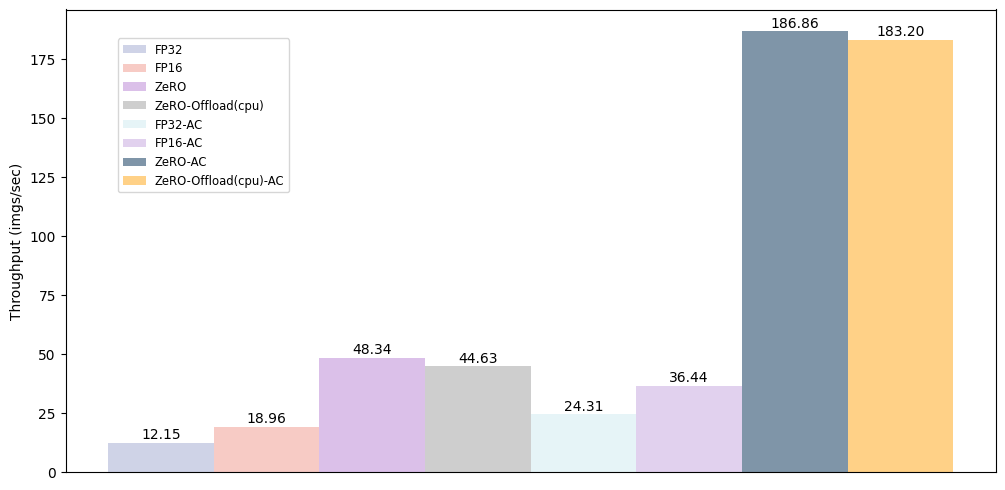

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

colors = [
    '#A1A9D0',
    '#F0988C',
    '#B883D4',
    '#9E9E9E',
    '#CFEAF1',
    '#C4A5DE',
    '#002c53',
    '#ffa510',
    '#0c84c6',
    '#f74d4d',
    '#2455a4',
    '#41b7ac',
    '#2455a6',
    '#41b7af',
]

setting2name = {
    # ac, fp16, pipeline, zero, offload
    (0,0,0,0,np.nan): 'FP32',
    (0,1,0,0,np.nan): 'FP16',
    (0,1,0,1,np.nan): 'ZeRO',
    (0,1,0,1,'cpu'): 'ZeRO-Offload(cpu)',
    (0,0,1,0,np.nan): 'Pipeline',
    (0,1,1,0,np.nan): 'Pipeline-FP16',
    (1,0,0,0,np.nan): 'FP32-AC',  
    (1,1,0,0,np.nan): 'FP16-AC',  
    (1,1,0,1,np.nan): 'ZeRO-AC', 
    (1,1,0,1,'cpu'): 'ZeRO-Offload(cpu)-AC', 
    (1,0,1,0,np.nan): 'Pipeline-AC',
    (1,1,1,0,np.nan): 'Pipeline-FP16-AC',
}

def sort_data_via_labels(data, labels=None):
    # map index to label
    if labels is None:
        labels = list(setting2name.values())
    label2index = {label: i for i, label in enumerate(labels)}
    return [data[label2index[label]] for label in labels]
    
def plot(origin_df, model_name, gpus, img_size):
    # 读取数据文件
    df1 = origin_df.copy(deep=True)

    # 筛选出 gpus=2 的数据
    df1 = df1[df1['model']==model_name]
    df1 = df1[df1['gpus']==gpus]
    df1 = df1[df1['img_size']==img_size]
    df1 = df1[df1['GPU_Peak_Memory']>20]
    df1 = df1.sort_values(by=['batch_size'])
    groups = df1.groupby(['key'])

    # 绘制柱状图和箱图
    fig, ax1 = plt.subplots(figsize=(12, 6))
    # ax2 = ax1.twinx()

    bar_width = 0.2
    opacity = 0.5
    length = len(groups)
    bar_width = 2
    interval = bar_width * length + 2
    batch_size = None
    label_order = list(setting2name.values())
    data  = {}
    for i, (setting, group) in enumerate(groups):
        get_item = lambda k: group[k].values.tolist()[0]
        ac, fp16, pipeline, zero, offload = get_item('ac'), get_item('fp16'), get_item('pipeline'), get_item('zero'), get_item('offload')
        setting = (ac, fp16, pipeline, zero, offload)
        label = setting2name[setting]
        # print(setting, label)
        data[label] = {
            'gpus': group['gpus'].values.tolist(),
            'batch_size': group['batch_size'].values.tolist(),
            'ThroughPut': group['ThroughPut'].values.tolist(),
            'GPU_Peak_Memory': group['GPU_Peak_Memory'].values.tolist(),
            'CPU_Peak_Memory': group['CPU_Peak_Memory'].values.tolist(),
        }
    i = -1
    for label in label_order:
        if label not in data:
            continue
        i += 1
        x_axis = (i+1) * bar_width + 1
        print(label, data[label])
        # FP32 {'gpus': [1], 'batch_size': [4], 'ThroughPut': [3.201202671518686], 'GPU_Peak_Memory': [23.54], 'CPU_Peak_Memory': [17.59]}
        # FP16 {'gpus': [1], 'batch_size': [8], 'ThroughPut': [4.834867798685742], 'GPU_Peak_Memory': [25.52], 'CPU_Peak_Memory': [17.55]}
        
        # 绘制 Throughput 柱状图
        y_left = data[label]['ThroughPut'][-1]
        y_right = data[label]['GPU_Peak_Memory'][-1]
        ax1.bar(x_axis, y_left, color=colors[i%length], width=bar_width, align='center', label=label, alpha=opacity)
        ax1.text(x_axis, y_left+0.5, f'{y_left:.2f}', ha='center', va='bottom', fontsize=10)
        
        # 绘制 GPU Peak Memory 散点图
        # ax2.scatter(x_axis, y_right, marker='x', color=colors[i%length], label=label)

    # 设置坐标轴和图例
    ax1.set_ylabel('Throughput (imgs/sec)')
    # ax2.set_ylabel('GPU Peak Memory (MB)')
    ax1.legend(loc='upper left', bbox_to_anchor=(0.05, 0.95), fontsize='small')
    # plt.title(f'Performance Comparison of {model_name} on {gpus} GPUs with 3x{img_size}x{img_size} input')
    plt.xticks([])
    plt.show()

plot(new_df, 'darts', 4, 224)

/tmp/ipykernel_2092/3316244060.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['model']==model_name][df1['gpus']==gpus][df1['img_size']==img_size].sort_values(by=['batch_size'])


(1, 0, 0, 0, nan) FP32-AC
(0, 1, 0, 0, nan) FP16
(1, 1, 0, 0, nan) FP16-AC
(0, 1, 0, 1, 'cpu') ZeRO-Offload(cpu)
(1, 1, 0, 1, 'cpu') ZeRO-Offload(cpu)-AC
(0, 1, 0, 1, nan) ZeRO
(1, 1, 0, 1, nan) ZeRO-AC
(0, 0, 0, 0, nan) FP32


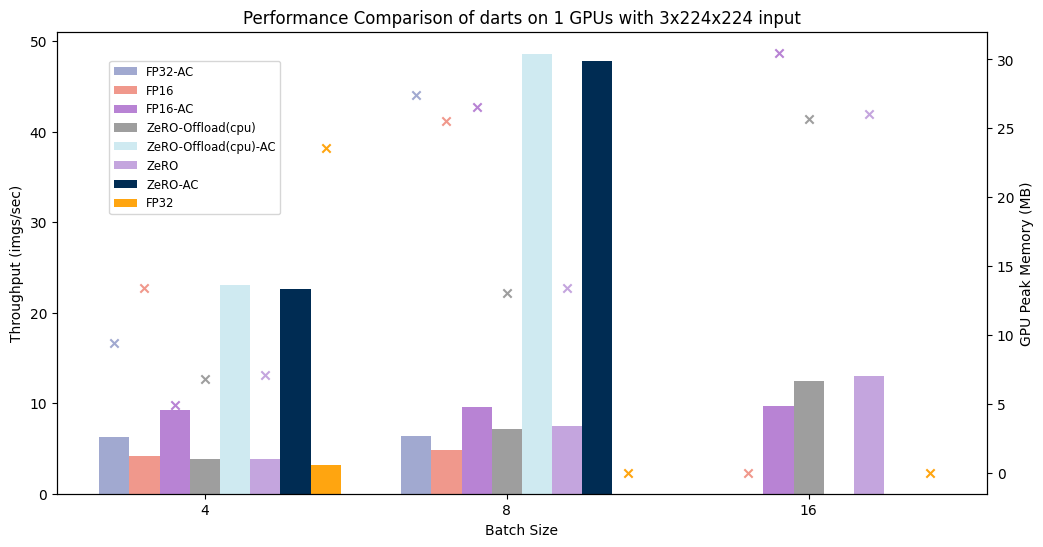

In [84]:
plot(new_df, 'darts', 1, 224)

In [77]:

new_df = df.sort_values(by=['model', 'gpus', 'img_size', 'batch_size', 'ac', 'fp16', 'pipeline', 'zero', 'offload'])
new_df.to_csv(f'./results/all_df.csv')
new_df

,model,gpus,batch_size,img_size,ac,fp16,pipeline,zero,offload,key,ThroughPut,GPU_Peak_Memory,GPU_Peak_Memory_std,CPU_Peak_Memory,CPU_Peak_Memory_std,BatchTime_mean,BatchTime_std,path
18,darts,1,4,224,0,0,0,0,NaN,fp32,3.201203,23.54,1.291530e-29,17.59,1.291530e-29,1.249548,2.333610e-05,./logs/darts/ds_gpu1_4x224x224/2023-04-05-05:0...
19,darts,1,4,224,0,1,0,0,NaN,_fp16,4.210620,13.39,3.228826e-30,17.47,1.291530e-29,0.951240,1.086956e-03,./logs/darts/ds_gpu1_4x224x224_fp16/2023-04-05...
21,darts,1,4,224,0,1,0,1,cpu,_zero_offload(cpu)_fp16,3.849762,6.78,3.034884e-03,18.50,0.000000e+00,1.045884,7.359054e-03,./logs/darts/ds_gpu1_4x224x224_zero_offload(cp...
20,darts,1,4,224,0,1,0,1,NaN,_zero_offload(null)_fp16,3.855015,7.12,2.299154e-03,17.60,0.000000e+00,1.042787,5.528165e-03,./logs/darts/ds_gpu1_4x224x224_zero_fp16/2023-...
14,darts,1,8,224,0,0,0,0,NaN,fp32,0.000000,0.00,0.000000e+00,0.00,0.000000e+00,0.000000,0.000000e+00,./logs/darts/ds_gpu1_8x224x224/2023-04-05-05:0...
15,darts,1,8,224,0,1,0,0,NaN,_fp16,4.834868,25.52,1.291530e-29,17.55,1.291530e-29,1.654812,2.622784e-04,./logs/darts/ds_gpu1_8x224x224_fp16/2023-04-05...
17,darts,1,8,224,0,1,0,1,cpu,_zero_offload(cpu)_fp16,7.093892,13.05,1.157267e-02,18.53,1.291530e-29,1.134676,8.154776e-03,./logs/darts/ds_gpu1_8x224x224_zero_offload(cp...
16,darts,1,8,224,0,1,0,1,NaN,_zero_offload(null)_fp16,7.524796,13.39,1.013927e-02,17.61,0.000000e+00,1.068865,6.279449e-03,./logs/darts/ds_gpu1_8x224x224_zero_fp16/2023-...
0,darts,1,16,224,0,0,0,0,NaN,fp32,0.000000,0.00,0.000000e+00,0.00,0.000000e+00,0.000000,0.000000e+00,./logs/darts/ds_gpu1_16x224x224/2023-04-05-12:...
1,darts,1,16,224,0,1,0,0,NaN,_fp16,0.000000,0.00,0.000000e+00,0.00,0.000000e+00,0.000000,0.000000e+00,./logs/darts/ds_gpu1_16x224x224_fp16/2023-04-0...


In [79]:
df1 = new_df.copy(deep=True)
df1 = df1[df1['model']=='darts']
df1 = df1[df1['gpus']==4]
df1 = df1[df1['img_size']==224]
df1 = df1[df1['GPU_Peak_Memory']>20]
df1.drop(columns=['GPU_Peak_Memory_std'], inplace=True)
df1.sort_values(by=['key'])

,model,gpus,batch_size,img_size,ac,fp16,pipeline,zero,offload,key,ThroughPut,GPU_Peak_Memory,CPU_Peak_Memory,CPU_Peak_Memory_std,BatchTime_mean,BatchTime_std,path
33,darts,4,172,224,1,0,0,0,NaN,_ac,24.308968,24.63,26.92,1.162377e-28,7.083267,0.054810,./logs/darts/ds_gpu4_172x224x224_ac/2023-04-06...
30,darts,4,32,224,0,1,0,0,NaN,_fp16,18.961970,25.52,26.34,1.987315e-05,1.688281,0.001156,./logs/darts/ds_gpu4_32x224x224_fp16/2023-04-0...
25,darts,4,384,224,1,1,0,0,NaN,_fp16_ac,36.442297,26.58,27.62,1.322622e-03,10.543711,0.068343,./logs/darts/ds_gpu4_384x224x224_fp16_ac/2023-...
35,darts,4,64,224,0,1,0,1,cpu,_zero_offload(cpu)_fp16,44.626175,25.65,28.03,3.948203e-05,1.446624,0.018509,./logs/darts/ds_gpu4_64x224x224_zero_offload(c...
27,darts,4,384,224,1,1,0,1,cpu,_zero_offload(cpu)_fp16_ac,183.197545,25.64,29.06,8.131078e-04,2.106246,0.021024,./logs/darts/ds_gpu4_384x224x224_zero_offload(...
34,darts,4,64,224,0,1,0,1,NaN,_zero_offload(null)_fp16,48.335100,25.74,26.87,4.439746e-06,1.332875,0.012074,./logs/darts/ds_gpu4_64x224x224_zero_fp16/2023...
26,darts,4,384,224,1,1,0,1,NaN,_zero_offload(null)_fp16_ac,186.859112,25.74,27.98,2.241015e-05,2.064816,0.019789,./logs/darts/ds_gpu4_384x224x224_zero_fp16_ac/...
28,darts,4,16,224,0,0,0,0,NaN,fp32,12.152063,23.54,26.48,1.291530e-29,1.316947,0.000405,./logs/darts/ds_gpu4_16x224x224/2023-04-06-04:...


/tmp/ipykernel_2092/3799952233.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['model']==model_name][df1['gpus']==gpus][df1['img_size']==img_size].sort_values(by=['batch_size', 'zero', 'offload', 'pipeline', 'fp16', 'ac'])


error: darts due to object of type 'NoneType' has no len()


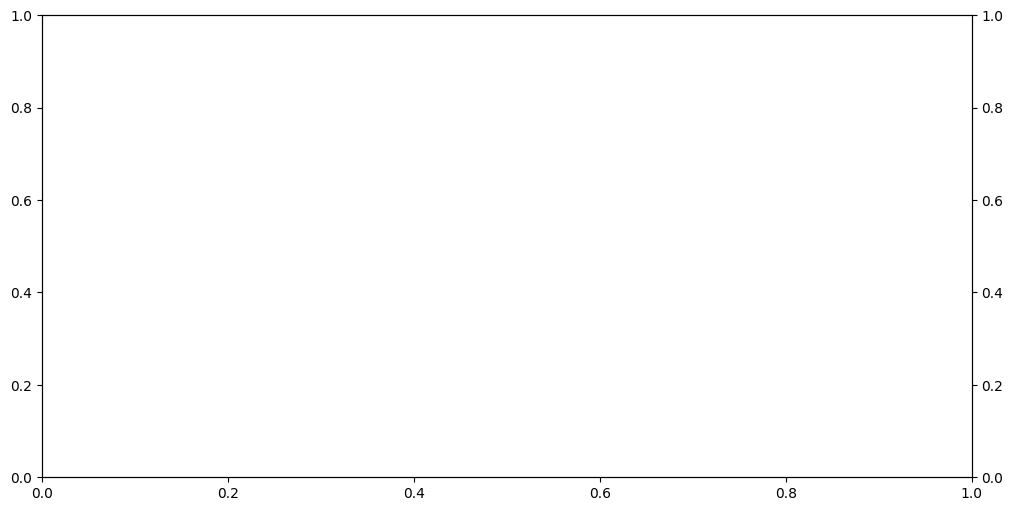

In [11]:
for model in new_df['model'].unique():
    try:
        plot(new_df, model, 2, 32)
    except Exception as e:
        print(f'error: {model} due to {e}')